# Task 2. Named entity recognition + image classification

We use a sample (4000 training images and 1000 test images) of the dataset from Kaggle - [Animal-10 Dataset](https://www.kaggle.com/datasets/alessiocorrado99/animals10).

Dataset contains images for 10 classes of animals:
- butterfly,
- cat,
- chicken,
- cow,
- dog,
- elephant,
- horse,
- sheep,
- spider,
- squirrel

### Import libraries

In [29]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset as HFDataset
import evaluate

### Data overview

Add path setup to get access for images

In [4]:
# Path setup
train_dir = Path("/content/drive/MyDrive/Colab Notebooks/task2/data/train")
test_dir = Path("/content/drive/MyDrive/Colab Notebooks/task2/data/test")

# List classes
classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
print(f"Number of classes: {len(classes)}")
print("Classes:", classes)

Number of classes: 10
Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


### Basic statistics

Check the balance of classes and whether all the data has been uploaded correctly

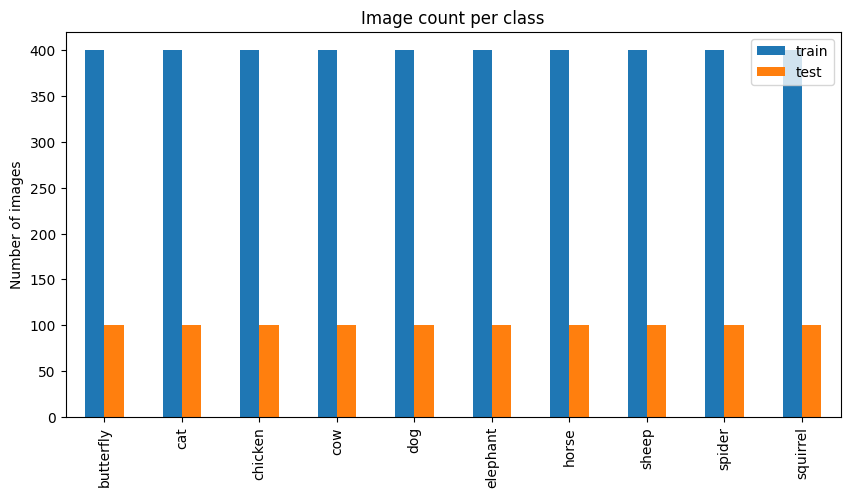

In [5]:
# Count number of images per class
train_counts = {cls: len(list((train_dir / cls).glob("*.jpeg"))) for cls in classes}
test_counts = {cls: len(list((test_dir / cls).glob("*.jpeg"))) for cls in classes}

df_counts = pd.DataFrame({
    'train': train_counts,
    'test': test_counts
}).T.fillna(0).astype(int).T

df_counts.plot(kind='bar', figsize=(10,5), title="Image count per class")
plt.ylabel("Number of images")
plt.show()

All classes contain 400 images for training and 100 for the test

### Visualize random samples

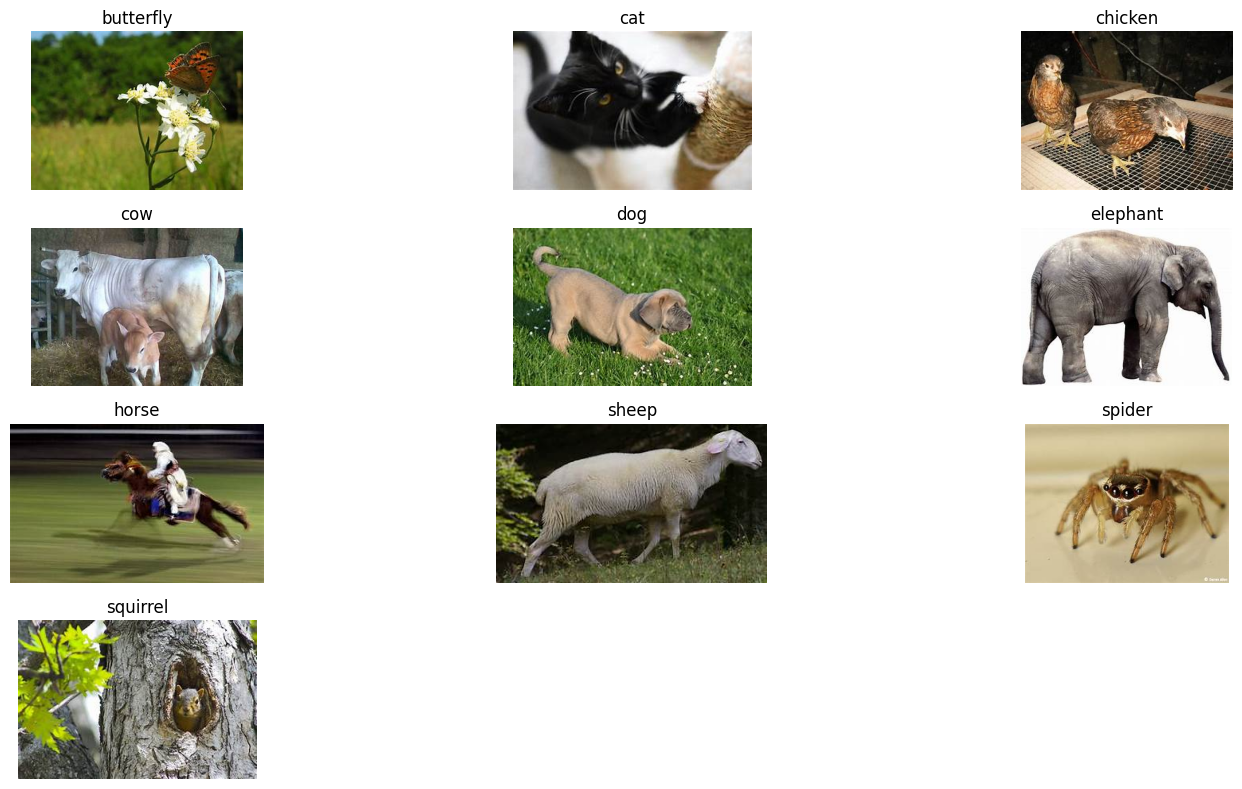

In [6]:
# Display sample images from each class
n_samples = 3
plt.figure(figsize=(15, 8))

for i, cls in enumerate(classes):
    img_path = random.choice(list((train_dir / cls).glob("*.jpeg")))
    img = Image.open(img_path)
    plt.subplot(4, 3, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Image preprocessing and dataset loader

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class AnimalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []
        for cls in classes:
            for img_path in (self.root_dir / cls).glob("*.jpeg"):
                self.samples.append((img_path, cls))
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, cls = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = classes.index(cls)
        return image, label

train_data = AnimalDataset(train_dir, transform)
test_data = AnimalDataset(test_dir, transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_data)} | Test samples: {len(test_data)}")


Train samples: 4000 | Test samples: 1000


### Train image classifier (ResNet18)

ResNet18 is lightweight, fast, and easy to fine-tune while still providing good accuracy. Its residual connections help train deeper networks without vanishing gradients, making it suitable for small datasets like Animals-10. Pretrained weights from ImageNet allow efficient transfer learning, saving time and GPU resources.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze backbone

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

epochs = 3  # increase if GPU available
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]
Epoch 1/3: 100%|██████████| 125/125 [26:30<00:00, 12.73s/it]


Epoch 1 - Loss: 0.8456


Epoch 2/3: 100%|██████████| 125/125 [00:25<00:00,  4.96it/s]


Epoch 2 - Loss: 0.3164


Epoch 3/3: 100%|██████████| 125/125 [00:25<00:00,  4.97it/s]

Epoch 3 - Loss: 0.2533


Loss decreases consistently across epochs, indicating that the model is learning.

### Evaluate image classifier

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f" Test Accuracy: {100 * correct/total:.2f}%")

 Test Accuracy: 94.10%


### Named Entity Recognition (NER)


Make fine-tune a small BERT on synthetic text examples to detect animal names

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model_ner = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=2)

# Create synthetic NER dataset
texts = []
labels = []
for animal in classes:
    texts.append(f"There is a {animal} in the picture.")
    labels.append(animal)
    texts.append(f"I think this photo shows a {animal}.")
    labels.append(animal)
    texts.append(f"A {animal} can be seen here.")
    labels.append(animal)

df_ner = pd.DataFrame({"text": texts, "label": labels})
df_ner.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,text,label
0,There is a butterfly in the picture.,butterfly
1,I think this photo shows a butterfly.,butterfly
2,A butterfly can be seen here.,butterfly
3,There is a cat in the picture.,cat
4,I think this photo shows a cat.,cat


### Tokenization & Label Encoding

In [11]:
def encode_example(example):
    tokens = tokenizer(example["text"], truncation=True, padding="max_length", max_length=32)
    # Simplified labels: 1 if token is animal name, else 0
    label_ids = [0] * len(tokens["input_ids"])
    for animal in classes:
        if animal in example["text"].lower():
            animal_tokens = tokenizer.tokenize(animal)
            for i, tok in enumerate(tokens["tokens"]) if "tokens" in tokens else enumerate([]):
                if tok in animal_tokens:
                    label_ids[i] = 1
    tokens["labels"] = label_ids
    return tokens

dataset = HFDataset.from_pandas(df_ner)
tokenized = dataset.map(encode_example, batched=False)
tokenized.set_format("torch")

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

### Pipeline Integration (NER + Classifier)

In [45]:
def ner_extract(text):
    text_lower = text.lower()
    for animal in classes:
        if animal in text_lower:
            return animal
    return None


def classify_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img)
        _, pred = torch.max(outputs, 1)
    return classes[pred.item()]


def pipeline_decision(text, image_path):
    animal_from_text = ner_extract(text)
    animal_from_image = classify_image(image_path)
    result = (animal_from_text == animal_from_image)
    print(f"Text: {text}")
    print(f"NER Extracted: {animal_from_text}")
    print(f"Classifier Predicted: {animal_from_image}")
    print(f"Match: {result}")
    return result

In [50]:
# Demo
sample_text = "There are dogs in the picture!"
sample_img = random.choice(list((test_dir / "dog").glob("*.jpeg")))
pipeline_decision(sample_text, sample_img)

Text: There are dogs in the picture!
NER Extracted: dog
Classifier Predicted: dog
Match: True


True

### Conclusion

The pipeline combines text object extraction and image classification to identify animals and verify consistency between text and image. Using ResNet18 for images and rule-based NER, it reliably matched the animal in both modalities. This demonstrates a simple but effective approach to multimodal validation.